# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [3]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [4]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [6]:
from tqdm import tqdm

### 训练器

In [7]:
def regressor_trainer(skmodel,
                      data_dict,
                      window_size=10,
                      epoch=1000,
                      eval_step=10,
                    on_test_log=False):
    mae_lst,rmse_lst = [], []
    for i in tqdm(range(epoch)):
        if i%eval_step==0 and on_test_log:
            print('---------------------------------------------------')
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            real_train_y = train_y[:,-1]
            
            test_x = train_data.copy()
        
            # (batch, window_size)-->(batch, 1)
            skmodel.fit(train_x,real_train_y)
    
            # Eval on every eval_step
            if (i+1)%eval_step==0:
                test_x = train_data.copy()
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    online_x = np.reshape(np.array(test_x[-window_size:]), (-1, window_size)).astype(np.float32)
            
                    next_point = skmodel.predict(online_x)[0]
                    
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                
                mae, rmse = evaluation(y_test=test_data, y_predict=point_list)

                mae_lst.append(mae)
                rmse_lst.append(rmse)

                if on_test_log:
                    print(f'Epoch:{i} {name} MAE:{mae:.4f} | RMSE:{rmse:<6.4f}')
    print(f'Model:{skmodel.__str__()}')
    print(f'MAE:{np.average(mae_lst):.4f} RMSE:{np.average(rmse_lst):.4f}')
    return skmodel

### 预测绘图

### 绘图函数

In [8]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 CNN

一维CNN，滑动窗口，在采样后的数据上做。

后续可考虑多层stack。

In [9]:
from typing import List,Dict,Tuple

In [10]:
from collections import OrderedDict

In [11]:
import torch

In [12]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [13]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [14]:
class CNNSingleModel(BaseModel):

    def __init__(self,
                 kernel_size:int,
                 stride:int,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(CNNSingleModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )
        if kernel_size>self.prefix_length:
            assert(f'Error kernel_size:{kernel_size} must less than prefix_length:{self.prefix_length}')
        
        self.CNNLayer = torch.nn.Conv1d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=kernel_size,
                                        stride=stride)
        
        self.OutputLinear = torch.nn.Linear(in_features=int((self.prefix_length-kernel_size+1)/stride),
                                            out_features=1,
                                            bias=False)
        self.__post_init__()
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = self.CNNLayer(x)
        y = self.OutputLinear(x)
        return y.reshape((y.shape[0],1))

In [26]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-3    # learning rate
weight_decay = 0.0
kernel_size = 16
stride = 1
batch_size = 512

In [16]:
eval_step = 1000

In [17]:
data_dict = bmap

In [18]:
model = CNNSingleModel(kernel_size=kernel_size,
                       stride=stride,
                 prefix_length=window_size)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [20]:
on_test_log = True

In [21]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [28]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|                                                                     | 1/1000000 [00:00<31:50:37,  8.72it/s]

---------------------------------------------------
Epoch:0 Loss:0.00095577 MAE:0.5296 | RMSE:0.5647


  0%|                                                                   | 1003/1000000 [00:27<9:57:47, 27.85it/s]

---------------------------------------------------
Epoch:1000 Loss:0.00027532 MAE:0.2972 | RMSE:0.3185


  0%|▏                                                                  | 2001/1000000 [00:58<9:36:01, 28.88it/s]

---------------------------------------------------
Epoch:2000 Loss:0.00027423 MAE:0.2196 | RMSE:0.2363


  0%|▏                                                                  | 2999/1000000 [01:28<7:49:32, 35.39it/s]

---------------------------------------------------
Epoch:3000 Loss:0.00027386 MAE:0.1807 | RMSE:0.1952


  0%|▎                                                                  | 4001/1000000 [01:58<9:46:09, 28.32it/s]

---------------------------------------------------
Epoch:4000 Loss:0.00027368 MAE:0.1574 | RMSE:0.1704


  1%|▎                                                                 | 5003/1000000 [02:28<10:45:26, 25.69it/s]

---------------------------------------------------
Epoch:5000 Loss:0.00027357 MAE:0.1418 | RMSE:0.1540


  1%|▍                                                                 | 6000/1000000 [03:09<11:23:11, 24.25it/s]

---------------------------------------------------
Epoch:6000 Loss:0.00027349 MAE:0.1307 | RMSE:0.1422


  1%|▍                                                                 | 7000/1000000 [03:51<12:06:35, 22.78it/s]

---------------------------------------------------
Epoch:7000 Loss:0.00027344 MAE:0.1224 | RMSE:0.1333


  1%|▌                                                                 | 8000/1000000 [04:31<10:33:09, 26.11it/s]

---------------------------------------------------
Epoch:8000 Loss:0.00027339 MAE:0.1159 | RMSE:0.1264


  1%|▌                                                                 | 9002/1000000 [05:13<12:49:41, 21.46it/s]

---------------------------------------------------
Epoch:9000 Loss:0.00027336 MAE:0.1107 | RMSE:0.1209


  1%|▋                                                                | 10001/1000000 [05:53<10:24:55, 26.40it/s]

---------------------------------------------------
Epoch:10000 Loss:0.00027333 MAE:0.1064 | RMSE:0.1164


  1%|▋                                                                | 11001/1000000 [06:26<10:47:54, 25.44it/s]

---------------------------------------------------
Epoch:11000 Loss:0.00027331 MAE:0.1028 | RMSE:0.1127


  1%|▊                                                                | 12002/1000000 [06:56<10:11:04, 26.95it/s]

---------------------------------------------------
Epoch:12000 Loss:0.00027329 MAE:0.0998 | RMSE:0.1095


  1%|▊                                                                 | 13002/1000000 [07:25<9:48:34, 27.95it/s]

---------------------------------------------------
Epoch:13000 Loss:0.00027327 MAE:0.0973 | RMSE:0.1068


  1%|▉                                                                | 13999/1000000 [08:05<11:25:00, 23.99it/s]

---------------------------------------------------


  1%|▉                                                                | 14005/1000000 [08:05<14:47:39, 18.51it/s]

Epoch:14000 Loss:0.00027326 MAE:0.0950 | RMSE:0.1044


  2%|▉                                                                | 15000/1000000 [08:47<11:32:54, 23.69it/s]

---------------------------------------------------
Epoch:15000 Loss:0.00027325 MAE:0.0931 | RMSE:0.1023


  2%|█                                                                | 16001/1000000 [09:29<13:53:39, 19.67it/s]

---------------------------------------------------
Epoch:16000 Loss:0.00027323 MAE:0.0913 | RMSE:0.1005


  2%|█                                                                | 17001/1000000 [10:09<13:34:42, 20.11it/s]

---------------------------------------------------
Epoch:17000 Loss:0.00027322 MAE:0.0898 | RMSE:0.0989


  2%|█▏                                                               | 18002/1000000 [10:44<11:10:14, 24.42it/s]

---------------------------------------------------
Epoch:18000 Loss:0.00027321 MAE:0.0884 | RMSE:0.0974


  2%|█▏                                                               | 19003/1000000 [11:14<10:07:21, 26.92it/s]

---------------------------------------------------
Epoch:19000 Loss:0.00027321 MAE:0.0872 | RMSE:0.0961


  2%|█▎                                                               | 20003/1000000 [11:44<10:15:20, 26.54it/s]

---------------------------------------------------
Epoch:20000 Loss:0.00027320 MAE:0.0861 | RMSE:0.0949


  2%|█▎                                                               | 21001/1000000 [12:22<13:42:48, 19.83it/s]

---------------------------------------------------
Epoch:21000 Loss:0.00027319 MAE:0.0851 | RMSE:0.0938


  2%|█▍                                                               | 22001/1000000 [13:03<14:45:31, 18.41it/s]

---------------------------------------------------
Epoch:22000 Loss:0.00027318 MAE:0.0841 | RMSE:0.0929


  2%|█▍                                                               | 22999/1000000 [13:45<11:20:04, 23.94it/s]

---------------------------------------------------
Epoch:23000 Loss:0.00027318 MAE:0.0833 | RMSE:0.0919


  2%|█▌                                                               | 24001/1000000 [14:22<10:46:55, 25.14it/s]

---------------------------------------------------
Epoch:24000 Loss:0.00027317 MAE:0.0825 | RMSE:0.0911


  3%|█▋                                                                | 25002/1000000 [14:53<8:46:52, 30.84it/s]

---------------------------------------------------
Epoch:25000 Loss:0.00027316 MAE:0.0818 | RMSE:0.0903


  3%|█▋                                                                | 26003/1000000 [15:20<8:50:30, 30.60it/s]

---------------------------------------------------
Epoch:26000 Loss:0.00027316 MAE:0.0811 | RMSE:0.0896


  3%|█▊                                                               | 26999/1000000 [15:48<10:40:22, 25.32it/s]

---------------------------------------------------
Epoch:27000 Loss:0.00027315 MAE:0.0805 | RMSE:0.0890


  3%|█▊                                                               | 28000/1000000 [16:34<10:17:15, 26.25it/s]

---------------------------------------------------
Epoch:28000 Loss:0.00027315 MAE:0.0799 | RMSE:0.0884


  3%|█▉                                                               | 29000/1000000 [17:15<10:41:06, 25.24it/s]

---------------------------------------------------
Epoch:29000 Loss:0.00027314 MAE:0.0793 | RMSE:0.0878


  3%|█▉                                                               | 29999/1000000 [17:55<11:02:06, 24.42it/s]

---------------------------------------------------
Epoch:30000 Loss:0.00027314 MAE:0.0788 | RMSE:0.0872


  3%|██                                                                | 31000/1000000 [18:32<8:51:00, 30.41it/s]

---------------------------------------------------
Epoch:31000 Loss:0.00027314 MAE:0.0783 | RMSE:0.0867


  3%|██                                                                | 32000/1000000 [19:05<9:13:33, 29.14it/s]

---------------------------------------------------
Epoch:32000 Loss:0.00027313 MAE:0.0779 | RMSE:0.0863


  3%|██▏                                                              | 33002/1000000 [19:43<11:57:49, 22.45it/s]

---------------------------------------------------
Epoch:33000 Loss:0.00027313 MAE:0.0775 | RMSE:0.0858


  3%|██▏                                                              | 33998/1000000 [20:16<11:25:05, 23.50it/s]

---------------------------------------------------


  3%|██▏                                                              | 34003/1000000 [20:16<15:31:42, 17.28it/s]

Epoch:34000 Loss:0.00027312 MAE:0.0771 | RMSE:0.0854


  4%|██▎                                                              | 35001/1000000 [21:04<14:30:39, 18.47it/s]

---------------------------------------------------
Epoch:35000 Loss:0.00027312 MAE:0.0767 | RMSE:0.0850


  4%|██▎                                                              | 36002/1000000 [21:48<13:17:44, 20.14it/s]

---------------------------------------------------
Epoch:36000 Loss:0.00027312 MAE:0.0763 | RMSE:0.0846


  4%|██▍                                                               | 37002/1000000 [22:21<9:52:27, 27.09it/s]

---------------------------------------------------
Epoch:37000 Loss:0.00027312 MAE:0.0760 | RMSE:0.0843


  4%|██▌                                                               | 38000/1000000 [22:51<7:41:12, 34.76it/s]

---------------------------------------------------
Epoch:38000 Loss:0.00027311 MAE:0.0757 | RMSE:0.0839


  4%|██▌                                                               | 39005/1000000 [23:19<7:46:25, 34.34it/s]

---------------------------------------------------
Epoch:39000 Loss:0.00027311 MAE:0.0754 | RMSE:0.0836


  4%|██▋                                                               | 40004/1000000 [23:48<8:43:47, 30.55it/s]

---------------------------------------------------
Epoch:40000 Loss:0.00027311 MAE:0.0751 | RMSE:0.0833


  4%|██▋                                                              | 41002/1000000 [24:20<10:31:32, 25.31it/s]

---------------------------------------------------
Epoch:41000 Loss:0.00027310 MAE:0.0748 | RMSE:0.0830


  4%|██▊                                                               | 42000/1000000 [24:51<9:49:52, 27.07it/s]

---------------------------------------------------
Epoch:42000 Loss:0.00027310 MAE:0.0746 | RMSE:0.0827


  4%|██▊                                                               | 42999/1000000 [25:29<9:56:17, 26.75it/s]

---------------------------------------------------


  4%|██▊                                                              | 43005/1000000 [25:29<13:40:13, 19.45it/s]

Epoch:43000 Loss:0.00027310 MAE:0.0743 | RMSE:0.0825


  4%|██▉                                                               | 43999/1000000 [26:03<9:53:49, 26.83it/s]

---------------------------------------------------


  4%|██▊                                                              | 44005/1000000 [26:03<13:08:45, 20.20it/s]

Epoch:44000 Loss:0.00027310 MAE:0.0741 | RMSE:0.0822


  4%|██▉                                                               | 45000/1000000 [26:37<7:43:37, 34.33it/s]

---------------------------------------------------
Epoch:45000 Loss:0.00027309 MAE:0.0738 | RMSE:0.0820


  5%|███                                                               | 46001/1000000 [27:06<8:52:15, 29.87it/s]

---------------------------------------------------
Epoch:46000 Loss:0.00027309 MAE:0.0736 | RMSE:0.0817


  5%|███                                                               | 47001/1000000 [27:33<7:53:20, 33.56it/s]

---------------------------------------------------
Epoch:47000 Loss:0.00027309 MAE:0.0734 | RMSE:0.0815


  5%|███                                                              | 48001/1000000 [28:01<10:58:38, 24.09it/s]

---------------------------------------------------
Epoch:48000 Loss:0.00027309 MAE:0.0732 | RMSE:0.0813


  5%|███▏                                                             | 48999/1000000 [28:51<13:48:27, 19.13it/s]

---------------------------------------------------


  5%|███▏                                                             | 49004/1000000 [28:51<17:14:06, 15.33it/s]

Epoch:49000 Loss:0.00027308 MAE:0.0730 | RMSE:0.0811


  5%|███▏                                                             | 49999/1000000 [29:44<13:17:02, 19.87it/s]

---------------------------------------------------
Epoch:50000 Loss:0.00027308 MAE:0.0728 | RMSE:0.0809


  5%|███▎                                                             | 51000/1000000 [30:34<20:05:50, 13.12it/s]

---------------------------------------------------


  5%|███▎                                                             | 51002/1000000 [30:34<34:52:57,  7.56it/s]

Epoch:51000 Loss:0.00027308 MAE:0.0726 | RMSE:0.0807


  5%|███▍                                                             | 51999/1000000 [31:25<14:01:10, 18.78it/s]

---------------------------------------------------


  5%|███▍                                                             | 52003/1000000 [31:26<20:27:57, 12.87it/s]

Epoch:52000 Loss:0.00027308 MAE:0.0725 | RMSE:0.0805


  5%|███▍                                                             | 52999/1000000 [32:17<14:36:21, 18.01it/s]

---------------------------------------------------


  5%|███▍                                                             | 53003/1000000 [32:18<20:07:45, 13.07it/s]

Epoch:53000 Loss:0.00027308 MAE:0.0723 | RMSE:0.0803


  5%|███▌                                                             | 53999/1000000 [33:21<15:48:23, 16.62it/s]

---------------------------------------------------


  5%|███▌                                                             | 54003/1000000 [33:21<21:47:48, 12.06it/s]

Epoch:54000 Loss:0.00027308 MAE:0.0721 | RMSE:0.0802


  5%|███▌                                                             | 54999/1000000 [34:25<17:44:53, 14.79it/s]

---------------------------------------------------


  6%|███▌                                                             | 55003/1000000 [34:25<25:00:48, 10.49it/s]

Epoch:55000 Loss:0.00027307 MAE:0.0720 | RMSE:0.0800


  6%|███▋                                                             | 55999/1000000 [35:22<12:17:51, 21.32it/s]

---------------------------------------------------


  6%|███▋                                                             | 56005/1000000 [35:23<14:52:23, 17.63it/s]

Epoch:56000 Loss:0.00027307 MAE:0.0718 | RMSE:0.0798


  6%|███▋                                                             | 56999/1000000 [36:16<13:03:00, 20.07it/s]

---------------------------------------------------


  6%|███▋                                                             | 57004/1000000 [36:17<16:33:55, 15.81it/s]

Epoch:57000 Loss:0.00027307 MAE:0.0717 | RMSE:0.0797


  6%|███▊                                                             | 57999/1000000 [37:04<13:06:31, 19.96it/s]

---------------------------------------------------


  6%|███▊                                                             | 58003/1000000 [37:04<18:19:41, 14.28it/s]

Epoch:58000 Loss:0.00027307 MAE:0.0715 | RMSE:0.0795


  6%|███▊                                                             | 58998/1000000 [37:52<12:01:58, 21.72it/s]

---------------------------------------------------


  6%|███▊                                                             | 59003/1000000 [37:52<15:53:56, 16.44it/s]

Epoch:59000 Loss:0.00027307 MAE:0.0714 | RMSE:0.0794


  6%|███▉                                                             | 59999/1000000 [38:40<12:18:20, 21.22it/s]

---------------------------------------------------


  6%|███▉                                                             | 60005/1000000 [38:40<16:11:38, 16.12it/s]

Epoch:60000 Loss:0.00027307 MAE:0.0713 | RMSE:0.0793


  6%|███▉                                                             | 60998/1000000 [39:30<14:01:00, 18.61it/s]

---------------------------------------------------


  6%|███▉                                                             | 61003/1000000 [39:31<18:45:19, 13.91it/s]

Epoch:61000 Loss:0.00027306 MAE:0.0711 | RMSE:0.0791


  6%|████                                                             | 62000/1000000 [40:19<12:21:32, 21.08it/s]

---------------------------------------------------


  6%|████                                                             | 62003/1000000 [40:20<18:05:04, 14.41it/s]

Epoch:62000 Loss:0.00027306 MAE:0.0710 | RMSE:0.0790


  6%|████                                                             | 63001/1000000 [41:08<15:12:19, 17.12it/s]

---------------------------------------------------
Epoch:63000 Loss:0.00027306 MAE:0.0709 | RMSE:0.0789


  6%|████▏                                                            | 64001/1000000 [41:59<19:25:38, 13.38it/s]

---------------------------------------------------
Epoch:64000 Loss:0.00027306 MAE:0.0708 | RMSE:0.0787


  6%|████▏                                                            | 64998/1000000 [42:47<10:43:43, 24.21it/s]

---------------------------------------------------


  7%|████▏                                                            | 65004/1000000 [42:47<14:58:47, 17.34it/s]

Epoch:65000 Loss:0.00027306 MAE:0.0707 | RMSE:0.0786


  7%|████▎                                                            | 65999/1000000 [43:33<10:24:24, 24.93it/s]

---------------------------------------------------
Epoch:66000 Loss:0.00027306 MAE:0.0706 | RMSE:0.0785


  7%|████▎                                                            | 67000/1000000 [44:14<12:07:34, 21.37it/s]

---------------------------------------------------


  7%|████▎                                                            | 67003/1000000 [44:14<16:34:23, 15.64it/s]

Epoch:67000 Loss:0.00027306 MAE:0.0705 | RMSE:0.0784


  7%|████▍                                                            | 68000/1000000 [45:05<16:03:30, 16.12it/s]

---------------------------------------------------


  7%|████▍                                                            | 68004/1000000 [45:05<22:15:52, 11.63it/s]

Epoch:68000 Loss:0.00027305 MAE:0.0704 | RMSE:0.0783


  7%|████▍                                                            | 68999/1000000 [46:04<17:49:23, 14.51it/s]

---------------------------------------------------


  7%|████▍                                                            | 69003/1000000 [46:05<25:17:41, 10.22it/s]

Epoch:69000 Loss:0.00027305 MAE:0.0703 | RMSE:0.0782


  7%|████▌                                                            | 69999/1000000 [47:09<16:06:44, 16.03it/s]

---------------------------------------------------


  7%|████▌                                                            | 70003/1000000 [47:09<23:14:33, 11.11it/s]

Epoch:70000 Loss:0.00027305 MAE:0.0702 | RMSE:0.0781


  7%|████▌                                                            | 71000/1000000 [48:10<16:09:42, 15.97it/s]

---------------------------------------------------


  7%|████▌                                                            | 71004/1000000 [48:10<22:28:39, 11.48it/s]

Epoch:71000 Loss:0.00027305 MAE:0.0701 | RMSE:0.0780


  7%|████▋                                                            | 71998/1000000 [49:01<12:19:51, 20.91it/s]

---------------------------------------------------


  7%|████▋                                                            | 72003/1000000 [49:01<15:58:52, 16.13it/s]

Epoch:72000 Loss:0.00027305 MAE:0.0700 | RMSE:0.0779


  7%|████▋                                                            | 72999/1000000 [49:47<12:27:35, 20.67it/s]

---------------------------------------------------


  7%|████▋                                                            | 73004/1000000 [49:48<17:10:12, 15.00it/s]

Epoch:73000 Loss:0.00027305 MAE:0.0699 | RMSE:0.0778


  7%|████▊                                                            | 73998/1000000 [50:39<13:27:51, 19.10it/s]

---------------------------------------------------


  7%|████▊                                                            | 74003/1000000 [50:39<18:07:10, 14.20it/s]

Epoch:74000 Loss:0.00027305 MAE:0.0698 | RMSE:0.0777


  7%|████▊                                                            | 74999/1000000 [51:28<12:32:47, 20.48it/s]

---------------------------------------------------


  8%|████▉                                                            | 75004/1000000 [51:28<16:14:51, 15.81it/s]

Epoch:75000 Loss:0.00027305 MAE:0.0697 | RMSE:0.0776


  8%|████▉                                                            | 75999/1000000 [52:16<13:46:48, 18.63it/s]

---------------------------------------------------


  8%|████▉                                                            | 76004/1000000 [52:16<17:43:29, 14.48it/s]

Epoch:76000 Loss:0.00027305 MAE:0.0696 | RMSE:0.0775


  8%|█████                                                            | 76998/1000000 [53:04<12:02:07, 21.30it/s]

---------------------------------------------------


  8%|█████                                                            | 77004/1000000 [53:05<15:48:02, 16.23it/s]

Epoch:77000 Loss:0.00027304 MAE:0.0696 | RMSE:0.0774


  8%|█████                                                            | 77998/1000000 [53:53<12:19:33, 20.78it/s]

---------------------------------------------------


  8%|█████                                                            | 78004/1000000 [53:54<15:24:48, 16.62it/s]

Epoch:78000 Loss:0.00027304 MAE:0.0695 | RMSE:0.0774


  8%|█████▏                                                           | 79000/1000000 [54:44<11:51:59, 21.56it/s]

---------------------------------------------------


  8%|█████▏                                                           | 79003/1000000 [54:45<16:31:01, 15.49it/s]

Epoch:79000 Loss:0.00027304 MAE:0.0694 | RMSE:0.0773


  8%|█████▏                                                           | 79999/1000000 [55:33<12:00:18, 21.29it/s]

---------------------------------------------------


  8%|█████▏                                                           | 80005/1000000 [55:34<15:17:00, 16.72it/s]

Epoch:80000 Loss:0.00027304 MAE:0.0693 | RMSE:0.0772


  8%|█████▎                                                           | 80999/1000000 [56:23<14:53:59, 17.13it/s]

---------------------------------------------------


  8%|█████▎                                                           | 81004/1000000 [56:23<18:06:27, 14.10it/s]

Epoch:81000 Loss:0.00027304 MAE:0.0693 | RMSE:0.0771


  8%|█████▎                                                           | 81999/1000000 [57:13<13:11:36, 19.33it/s]

---------------------------------------------------


  8%|█████▎                                                           | 82003/1000000 [57:14<18:59:56, 13.42it/s]

Epoch:82000 Loss:0.00027304 MAE:0.0692 | RMSE:0.0770


  8%|█████▍                                                           | 83000/1000000 [58:02<13:16:55, 19.18it/s]

---------------------------------------------------


  8%|█████▍                                                           | 83004/1000000 [58:03<19:00:57, 13.40it/s]

Epoch:83000 Loss:0.00027304 MAE:0.0691 | RMSE:0.0770


  8%|█████▍                                                           | 83998/1000000 [58:52<12:24:33, 20.50it/s]

---------------------------------------------------


  8%|█████▍                                                           | 84004/1000000 [58:53<15:23:23, 16.53it/s]

Epoch:84000 Loss:0.00027304 MAE:0.0690 | RMSE:0.0769


  8%|█████▌                                                           | 85000/1000000 [59:41<13:06:58, 19.38it/s]

---------------------------------------------------


  9%|█████▌                                                           | 85005/1000000 [59:42<16:19:03, 15.58it/s]

Epoch:85000 Loss:0.00027304 MAE:0.0690 | RMSE:0.0768


  9%|█████▍                                                         | 86000/1000000 [1:00:30<12:59:56, 19.53it/s]

---------------------------------------------------


  9%|█████▍                                                         | 86005/1000000 [1:00:30<16:07:06, 15.75it/s]

Epoch:86000 Loss:0.00027304 MAE:0.0689 | RMSE:0.0768


  9%|█████▍                                                         | 86999/1000000 [1:01:19<13:09:56, 19.26it/s]

---------------------------------------------------


  9%|█████▍                                                         | 87003/1000000 [1:01:20<17:53:52, 14.17it/s]

Epoch:87000 Loss:0.00027303 MAE:0.0689 | RMSE:0.0767


  9%|█████▌                                                         | 87999/1000000 [1:02:10<12:27:37, 20.33it/s]

---------------------------------------------------


  9%|█████▌                                                         | 88005/1000000 [1:02:10<15:31:33, 16.32it/s]

Epoch:88000 Loss:0.00027303 MAE:0.0688 | RMSE:0.0766


  9%|█████▌                                                         | 89000/1000000 [1:02:58<11:23:51, 22.20it/s]

---------------------------------------------------


  9%|█████▌                                                         | 89003/1000000 [1:02:58<15:40:16, 16.15it/s]

Epoch:89000 Loss:0.00027303 MAE:0.0687 | RMSE:0.0766


  9%|█████▋                                                         | 89999/1000000 [1:03:45<11:39:11, 21.69it/s]

---------------------------------------------------


  9%|█████▋                                                         | 90005/1000000 [1:03:45<15:04:48, 16.76it/s]

Epoch:90000 Loss:0.00027303 MAE:0.0687 | RMSE:0.0765


  9%|█████▋                                                         | 91000/1000000 [1:04:35<13:47:40, 18.30it/s]

---------------------------------------------------


  9%|█████▋                                                         | 91004/1000000 [1:04:36<18:59:09, 13.30it/s]

Epoch:91000 Loss:0.00027303 MAE:0.0686 | RMSE:0.0764


  9%|█████▋                                                         | 91099/1000000 [1:04:40<10:45:12, 23.48it/s]


KeyboardInterrupt: 

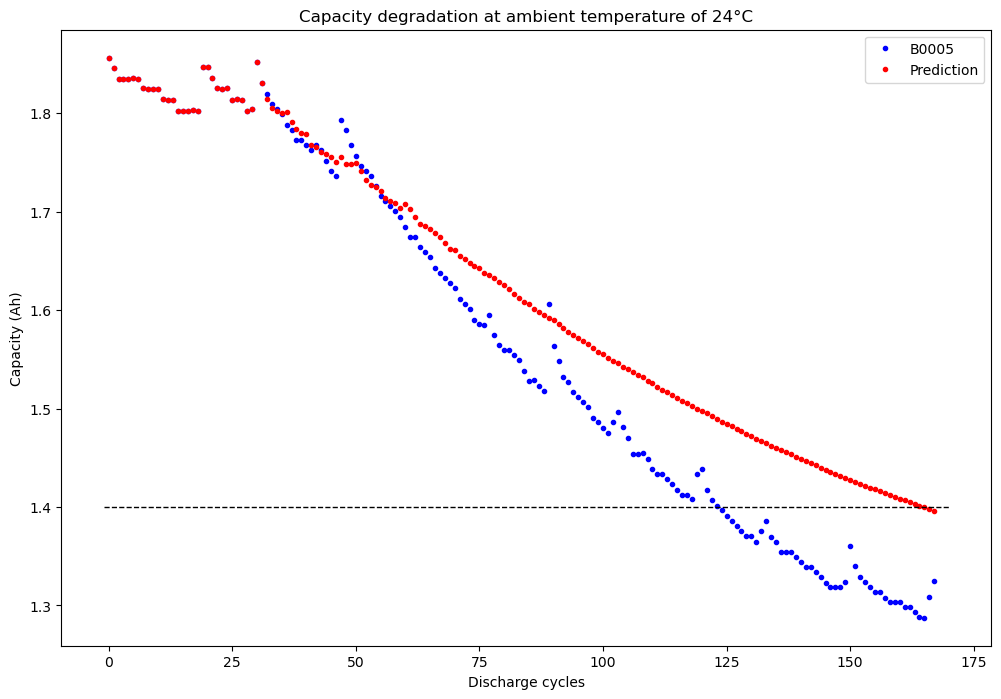

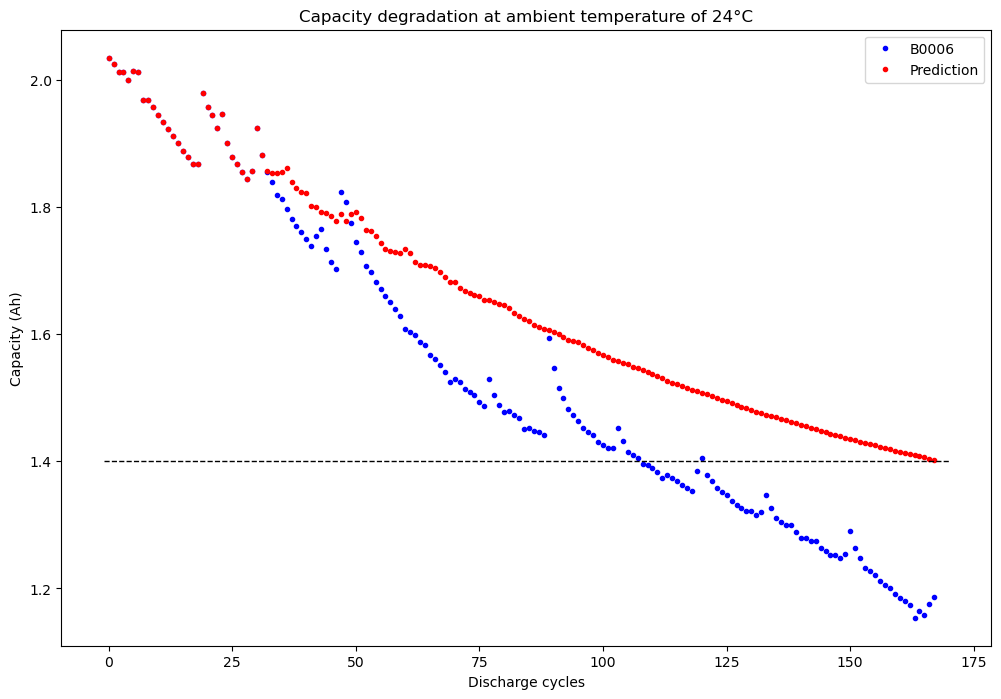

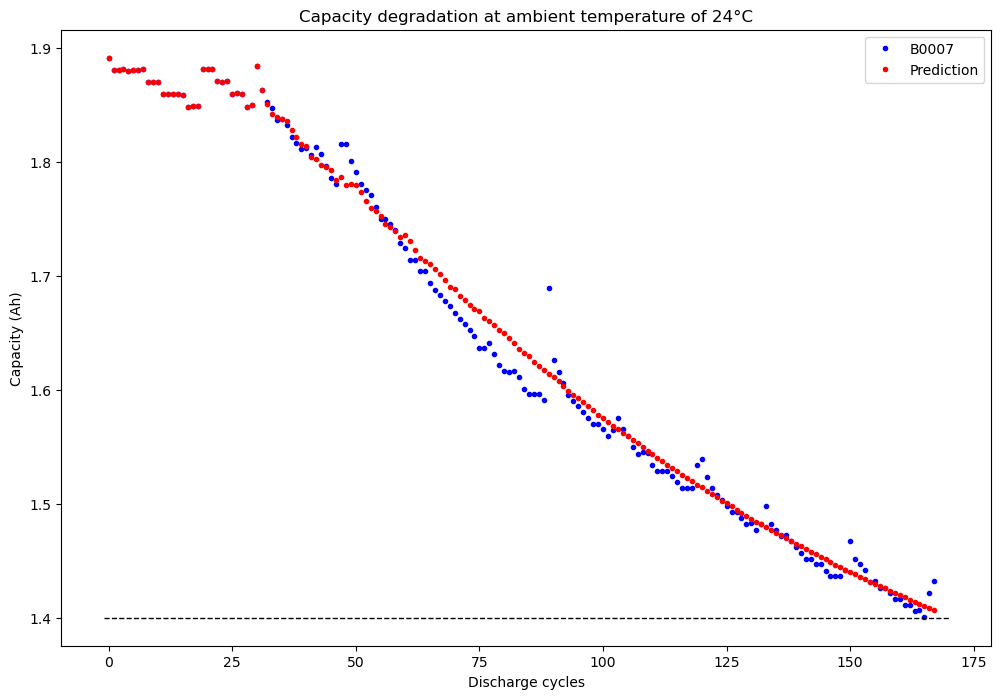

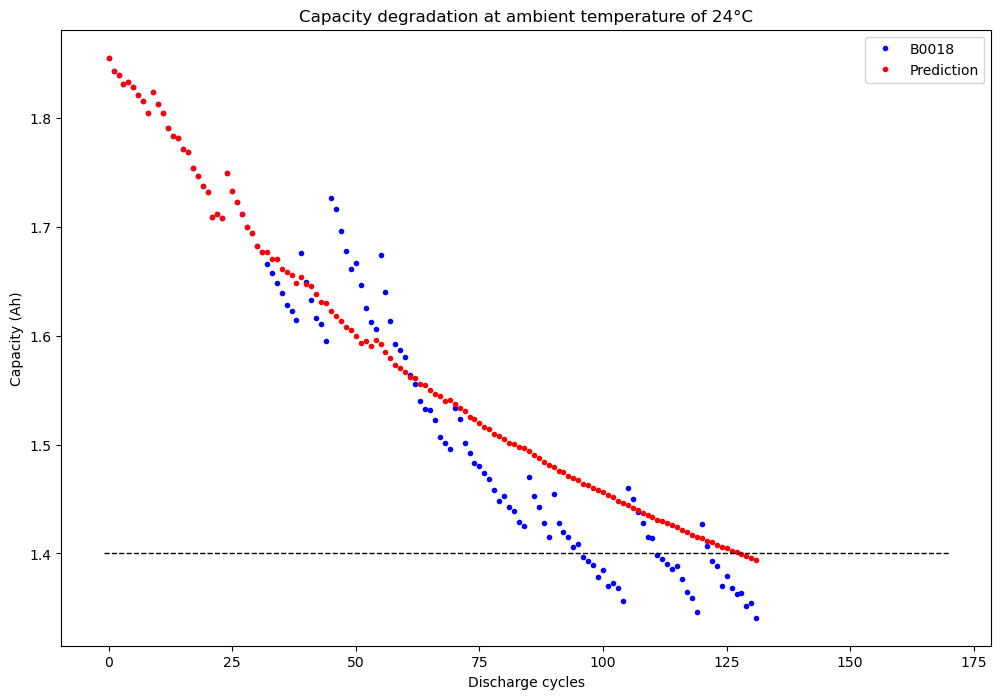

In [29]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)